In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [ ]:
IMG_SIZE = 96

X_train_resized = tf.image.resize(X_train, (IMG_SIZE, IMG_SIZE))
X_test_resized = tf.image.resize(X_test, (IMG_SIZE, IMG_SIZE))


In [ ]:
X_train_inc = preprocess_input(X_train_resized)
X_test_inc = preprocess_input(X_test_resized)


In [ ]:
# Load InceptionV3 base model
base_model = InceptionV3(
    input_shape=(96, 96, 3),   # valid (minimum is 75x75)
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(128, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dense(10, activation='softmax') # Output layer with 10 classes (Fashion MNIST)
])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3)
]


In [ ]:
history = model.fit(
    X_train_inc,
    y_train_cat,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)
test_loss, test_acc = model.evaluate(X_test_inc, y_test_cat)
print("Test accuracy:", test_acc)



Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5616 - loss: 1.2774 - val_accuracy: 0.6674 - val_loss: 0.9744 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7076 - loss: 0.8543 - val_accuracy: 0.6887 - val_loss: 0.9102 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7411 - loss: 0.7419 - val_accuracy: 0.6975 - val_loss: 0.8937 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7673 - loss: 0.6690 - val_accuracy: 0.7021 - val_loss: 0.8895 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7903 - loss: 0.6055 - val_accuracy: 0.7005 - val_loss: 0.9072 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8156 - loss: 0.5349 - val_accuracy: 0.6871 - val_loss: 0.9756 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8362 - loss: 0

The initial model performed adequately as an experimental baseline, achieving an accuracy of 69.39%. However, its performance confirms that simply reusing a pretrained model without additional adjustments is insufficient for more demanding classification tasks, thereby justifying the need to apply improvement techniques such as data augmentation, classifier optimization, and fine-tuning of the base model.


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1000
           1       0.73      0.83      0.78      1000
           2       0.68      0.67      0.67      1000
           3       0.52      0.62      0.56      1000
           4       0.68      0.56      0.61      1000
           5       0.73      0.59      0.66      1000
           6       0.68      0.73      0.70      1000
           7       0.67      0.76      0.71      1000
           8       0.73      0.78      0.76      1000
           9       0.79      0.72      0.75      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



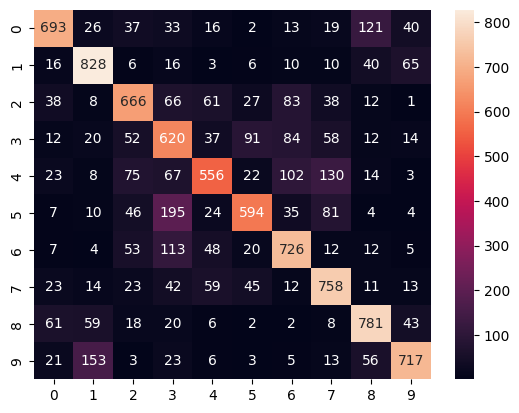

In [ ]:
y_pred = model.predict(X_test_inc)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


Improve model using data argument

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

IMG_SIZE = 128

X_train_resized = tf.image.resize(X_train, (IMG_SIZE, IMG_SIZE))
X_test_resized = tf.image.resize(X_test, (IMG_SIZE, IMG_SIZE))

X_train_inc = preprocess_input(X_train_resized)
X_test_inc = preprocess_input(X_test_resized)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])


base_model = InceptionV3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False



model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation='softmax')
])




In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.3)
]

history_1  = model.fit(
    X_train_inc,
    y_train_cat,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=callbacks
)
test_loss, test_acc = model.evaluate(X_test_inc, y_test_cat)
print("Test accuracy:", test_acc)



Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5913 - loss: 1.1640 - val_accuracy: 0.7651 - val_loss: 0.6874 - learning_rate: 9.0000e-05
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5989 - loss: 1.1566 - val_accuracy: 0.7595 - val_loss: 0.6936 - learning_rate: 9.0000e-05
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5923 - loss: 1.1650 - val_accuracy: 0.7608 - val_loss: 0.6866 - learning_rate: 9.0000e-05
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5994 - loss: 1.1474 - val_accuracy: 0.7606 - val_loss: 0.6875 - learning_rate: 9.0000e-05
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.6038 - loss: 1.1447 - val_accuracy: 0.7615 - val_loss: 0.6851 - learning_rate: 9.0000e-05
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5985 - loss: 1.1516 - val_accuracy: 0.7621 - val_loss: 0.6834 - learning_rate: 9.0000e-05
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/ste

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_2 = model.fit(
    X_train_inc,
    y_train_cat,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)
test_loss, test_acc = model.evaluate(X_test_inc, y_test_cat)
print("Test accuracy:", test_acc)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.5643 - loss: 1.2627 - val_accuracy: 0.7917 - val_loss: 0.6133 - learning_rate: 1.0000e-04
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.6326 - loss: 1.0545 - val_accuracy: 0.7984 - val_loss: 0.5789 - learning_rate: 1.0000e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.6631 - loss: 0.9713 - val_accuracy: 0.8045 - val_loss: 0.5765 - learning_rate: 1.0000e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.6908 - loss: 0.9001 - val_accuracy: 0.8150 - val_loss: 0.5532 - learning_rate: 1.0000e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.7087 - loss: 0.8469 - val_accuracy: 0.8065 - val_loss: 0.5672 - learning_rate: 1.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.7114 - loss: 0.8241 - val_accuracy: 0.8190 - val_loss: 0.5327 - learning_rate: 1.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/ste

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()
